In [1]:
import torch
from torch.utils.data import Dataset

import torchaudio
import torchaudio.transforms

import sys, os

from pprint import pprint

from tqdm.autonotebook import tqdm

import json

import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

import librosa
import librosa.display

import pandas as pd

from pathlib import Path

import gc

MANUAL_SEED = 69

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from datetime import date
from datetime import datetime

import os.path
from os import path
  
import json

import time

import copy

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
class FMADataset(Dataset):

  def __init__(
    self, path, normalize_audio, audio_num_frames, mean, std
  ):
    self.path = path
    self.normalize_audio = normalize_audio
    self.audio_num_frames = audio_num_frames
    self.mean = mean
    self.std = std
    
    self.data = self._load_audio_list()

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    
    try: 
      
      waveform, _ = torchaudio.load(
        filepath=self.data[idx], 
        normalize=self.normalize_audio,
        num_frames=self.audio_num_frames
      )
      
      if waveform.shape[1] < self.audio_num_frames:
        waveform = self._apply_padding(waveform)
      
      label = self.data[idx].split("/")[-2]
      label_one_hot = self._label_from_str_to_one_hot(label)

      waveform_normalized = (waveform - self.mean) / self.std
      
      return waveform_normalized, label_one_hot
    
    except Exception as e:
      print(f"Got the following exception for the file {self.data[idx]}")
      print("\n\n")
      print(e)
      
  def _apply_padding(self, to_pad):
    padding_size = self.audio_num_frames - to_pad.shape[1]
    
    return torch.nn.functional.pad(
      to_pad, (0, padding_size)
    )
  
  def _label_from_str_to_one_hot(self, label_str: str): 
  
    if label_str == "Pop":
      return torch.tensor([1, 0, 0, 0, 0, 0]).float()
    
    if label_str == "Hip-Hop":
      return torch.tensor([0, 1, 0, 0, 0, 0]).float()
    
    if label_str == "Electronic":
      return torch.tensor([0, 0, 1, 0, 0, 0]).float()
    
    if label_str == "Rock":
      return torch.tensor([0, 0, 0, 1, 0, 0]).float()

    if label_str == "Folk":
      return torch.tensor([0, 0, 0, 0, 1, 0]).float()

    if label_str == "Jazz":
      return torch.tensor([0, 0, 0, 0, 0, 1]).float()
    
  
  def _load_audio_list(self):
    
    audio_path_list = []
    
    for path, subdirs, files in tqdm(os.walk(self.path), colour="magenta"):
      for name in files:
          
        file_audio_path = os.path.join(path, name)
        
        audio_path_list.append(file_audio_path)
        
    return audio_path_list
        
        

In [4]:
DATASET_SIZE = "small"
DATASET_FOLDER = "./data/audio"

DATASET_NUM_SAMPLES_PER_SECOND = 8000
DATASET_NUM_CHANNELS = 1

DATASET_NAME = f"fma_{DATASET_SIZE}_organized_by_label_resampled_{DATASET_NUM_SAMPLES_PER_SECOND}_rechanneled_{DATASET_NUM_CHANNELS}"

dataset_path = f"{DATASET_FOLDER}/{DATASET_NAME}"

TRAINING_LOGS_FOLDER = "./logs"

NORMALIZE_AUDIO = True
AUDIO_NUM_FRAMES = 238000

In [5]:
summary_statistics_json = open(
  f"{dataset_path}_summary_statistics/{DATASET_NAME}_summary_statistics.json"
)

summary_statistics_dict = json.load(summary_statistics_json)

In [6]:
fma_dataset = FMADataset(
  path=dataset_path, 
  normalize_audio=NORMALIZE_AUDIO, 
  audio_num_frames=AUDIO_NUM_FRAMES,
  mean=summary_statistics_dict["mean"], 
  std=summary_statistics_dict["std"]
)

0it [00:00, ?it/s]

In [7]:
def make_dir_if_absent(dir_path):
  
  # print("making dir: ", dir_path)
  
  if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    

In [8]:
dataset_pca_df = pd.read_json(f"{dataset_path}_pca/{DATASET_NAME}_pca.json")

scaler = MinMaxScaler()

dataset_pca_df[
  ["dataset_pca_1_min_max_scaled","dataset_pca_2_min_max_scaled"]
] = pd.DataFrame(
  scaler.fit_transform(
    dataset_pca_df[
      ["dataset_pca_1","dataset_pca_2"]
    ].values
  ), 
  columns=["dataset_pca_1_min_max_scaled","dataset_pca_2_min_max_scaled"], 
  index=dataset_pca_df.index
)

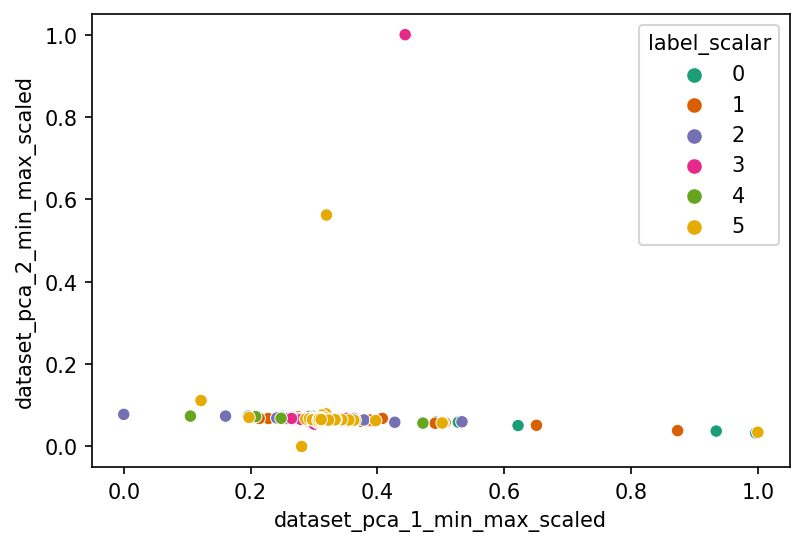

In [9]:
sns.scatterplot(
  data=dataset_pca_df,
  x="dataset_pca_1_min_max_scaled",
  y="dataset_pca_2_min_max_scaled",
  hue="label_scalar",
  palette="Dark2"
);

In [10]:
# len(fma_dataset)

In [11]:
TRAIN_PERCENTAGE = 0.7
VAL_PERCENTAGE = 0.2

full_size = len(fma_dataset)
train_size = int(TRAIN_PERCENTAGE * len(fma_dataset))
val_size = int(VAL_PERCENTAGE * len(fma_dataset))
test_size = full_size - train_size - val_size

In [12]:
generator=torch.Generator().manual_seed(MANUAL_SEED)

fma_dataset_train, fma_dataset_val, fma_dataset_test = torch.utils.data.random_split(
  fma_dataset, [train_size, val_size, test_size], generator
)

In [13]:
# print(f"len(fma_dataset_train): {len(fma_dataset_train)}")
# print(f"len(fma_dataset_val)  : {len(fma_dataset_val)}")
# print(f"len(fma_dataset_test) : {len(fma_dataset_test)}")

# **TODO reflect on this and use it as first hypothesis**

"the learning rate and batch size are closely linked — small batch sizes perform best with smaller learning rates, while large batch sizes do best on larger learning rates"

In [14]:
BATCH_SIZE = 16
NUM_WORKERS = 16

data_logs = {
  "dataset_size": DATASET_SIZE,
  "normalized_audio": NORMALIZE_AUDIO,
  "audio_num_frames": AUDIO_NUM_FRAMES,
  "batch_size": BATCH_SIZE,
  "num_samples_per_second": DATASET_NUM_SAMPLES_PER_SECOND,
  "num_channels": DATASET_NUM_CHANNELS
}

In [15]:
fma_dataloader_train = torch.utils.data.DataLoader(
  fma_dataset_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, 
  generator=generator
)
fma_dataloader_val = torch.utils.data.DataLoader(
  fma_dataset_val, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, 
  generator=generator
)
fma_dataloader_test = torch.utils.data.DataLoader(
  fma_dataset_test, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, 
  generator=generator
)

In [16]:
def count_num_trainable_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(
  torch.cuda.get_device_name(device) if torch.cuda.is_available() else "cpu"
)

cuda
NVIDIA GeForce RTX 2070


In [18]:
def gen_train_id():
  return datetime.now().strftime("%d_%m_%Y_%H_%M_%S")

In [19]:
def save_dict_to_disk(dict, full_path):
  with open(full_path, 'w') as fp:
    json.dump(dict, fp)

In [20]:
def store_ckp(
  model, optimizer, ckp_path, train_id, epoch, loss_train, loss_val, loss_test
):

  model_copy = copy.deepcopy(model)
  
  full_path_pth = f"{ckp_path}/{train_id}_epoch_{epoch}.pth"
  full_path_pickle = f"{ckp_path}/{train_id}_epoch_{epoch}"
  
  # print("STORING IN: ", full_path_pth)
  
  make_dir_if_absent(dir_path="/".join(full_path_pth.split('/')[:-1]))
  
  torch.save(
    {
      'epoch': epoch,
      'model_state_dict': model_copy.cpu().state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss_train': loss_train,
      'loss_val': loss_val,
      'loss_test': loss_test,
    }, 
    full_path_pth
  )
  
  torch.save(
    model_copy.cpu(), 
    full_path_pickle
  )

In [21]:
def load_ckp(ckp_path, perform_loading_sanity_check):

  loaded_model = torch.load(ckp_path)

  if perform_loading_sanity_check:

    loaded_model.eval()

    sanity_check_out = loaded_model(torch.rand((16, 1, 238000)))

  return loaded_model

In [22]:
def get_num_correct_preds(outputs, labels):
  
  output_pred_ind = torch.argmax(outputs, dim=1)
  labels_ind = torch.argmax(labels, dim=1)
  
  matching_mask = (output_pred_ind == labels_ind).float()
  
  num_correct_preds = matching_mask.sum()
  
  return num_correct_preds

In [23]:
def train_model(
  model, optimizer, criterion,
  batch_size, train_dl, val_dl, test_dl, num_epochs, device, 
  print_freq, ckp_freq, ckp_folder
):
  
  train_id = gen_train_id()
  
  training_logs = {
    "train_id": train_id,
    "accuracies": {},
    "losses": {}
  }
  
  model = model.to(device)
  
  pbar_epochs = tqdm(range(num_epochs), colour="#9400d3")
  pbar_batches_train = tqdm(
    iter(train_dl), colour="#4169e1", leave=False,
  )
  pbar_batches_val = tqdm(
    iter(val_dl), colour="#008080", leave=False,
  )
  
  training_start_time = time.time()

  for epoch in range(num_epochs):

    running_loss_train = 0.0
    running_loss_val   = 0.0
    running_loss_test  = -1.0
    
    num_correct_preds_train = 0.0
    num_preds_train = 0.0
    accuracy_train = 0.0
    
    num_correct_preds_val = 0.0
    num_preds_val = 0.0
    accuracy_val = 0.0
    
    num_correct_preds_test = 0.0
    num_preds_test = 0.000000001
    accuracy_test = 0.0
        
    ## BEGIN training step
    
    model.train()
    
    pbar_batches_train.reset()
    pbar_batches_val.reset()
    
    pbar_epochs.set_description(f"epoch {epoch}")
    pbar_batches_train.set_description(f"epoch {epoch}")
    pbar_batches_val.set_description  (f"epoch {epoch}")
    
    for batch_x, batch_y in iter(train_dl):

      inputs, labels = batch_x, batch_y
      inputs, labels = inputs.to(device), labels.to(device)
      
      optimizer.zero_grad()

      outputs = model(inputs)
      outputs = outputs.squeeze(-1)
      
      loss = criterion(outputs, labels)
      
      loss.backward()
      optimizer.step()

      # running_loss_train += loss.item() * inputs.shape[0]
      running_loss_train += loss.item() * batch_x.shape[0]
      
      num_correct_preds_train += get_num_correct_preds(outputs, labels)
      num_preds_train += outputs.shape[0]
      
      pbar_batches_train.update(1)
      
    
    ## END training step
    
    ## BEGIN validation step
    
    with torch.no_grad():
      
      model.eval()
      
      for batch_x, batch_y in iter(val_dl):

        inputs, labels = batch_x, batch_y
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        outputs = outputs.squeeze(-1)
        
        loss = criterion(outputs, labels)
        
        # running_loss_val += loss.item() * inputs.shape[0]
        running_loss_val += loss.item() * batch_x.shape[0]
        
        num_correct_preds_val += get_num_correct_preds(outputs, labels)
        num_preds_val += outputs.shape[0]
        
        pbar_batches_val.update(1)
        
    ## END validation step
    
    ## BEGIN test step
    
    if (epoch + 1 == num_epochs):
      
      pbar_batches_test = tqdm(
        iter(test_dl), colour="#808000", leave=False,
      )
      pbar_batches_test.set_description  (f"epoch {epoch}")
    
      with torch.no_grad():
        
        model.eval()
        
        for batch_x, batch_y in iter(test_dl):

          inputs, labels = batch_x, batch_y
          inputs, labels = inputs.to(device), labels.to(device)
          
          outputs = model(inputs)
          outputs = outputs.squeeze(-1)
          
          loss = criterion(outputs, labels)
          
          # running_loss_test += loss.item() * inputs.shape[0]
          running_loss_test += loss.item() * batch_x.shape[0]
          
          num_correct_preds_test += get_num_correct_preds(outputs, labels)
          num_preds_test += outputs.shape[0]
          
          pbar_batches_test.update(1)
        
    ## END test step
    
    accuracy_train = num_correct_preds_train / num_preds_train
    accuracy_val = num_correct_preds_val / num_preds_val
    accuracy_test = num_correct_preds_test / num_preds_test
    
    training_logs["accuracies"][str(epoch)] = {
      "accuracy_train": accuracy_train.cpu().item(),
      "accuracy_val": accuracy_val.cpu().item(),
    }
    training_logs["losses"][str(epoch)] = {
      "loss_train": running_loss_train,
      "loss_val": running_loss_val,
    }
    
    pbar_epochs.update(1)
    
    if ((epoch + 1) % print_freq == 0):  
      tqdm.write(
        f"epoch: {epoch + 1}\n" + 
        f"      train loss: {running_loss_train}, train acc: {accuracy_train}\n" + 
        f"      val loss  : {running_loss_val}, val acc  : {accuracy_val}\n"
      )
    
    if ((epoch + 1) == num_epochs):
      tqdm.write(
        f"      test loss : {running_loss_test}, test acc : {accuracy_test}"
      )
      
      training_logs["accuracies"][str(epoch)][
        "accuracy_test"
      ] = accuracy_test.cpu().item()
      
      training_logs["losses"][str(epoch)][
        "loss_test"
      ] = running_loss_test
      
    if (ckp_freq != None and (epoch + 1) % ckp_freq == 0):
      
      ckp_path = f"{ckp_folder}/{train_id}"
      
      store_ckp(
        model=model, optimizer=optimizer, ckp_path=ckp_path, epoch=epoch, 
        train_id=train_id,
        loss_train=running_loss_train, 
        loss_val=running_loss_val, 
        loss_test=running_loss_test
      )
  
  training_end_time = time.time()

  training_logs["training_time_secs"] = training_end_time - training_start_time

  return training_logs

## CNN

### Design motivations

First layers --> neural compression layers --> dimensionality reduction to roughly match dimensions of this paper https://arxiv.org/pdf/1703.01789.pdf

Mid and final layers --> taken 1:1 from the paper linked above

Batch norm placed BEFORE the activation function, as described in the og paper https://arxiv.org/abs/1502.03167 and explained by Bengio in his DL book https://www.deeplearningbook.org/contents/optimization.html in section 8.7.1

Dropout placed according to the og paper: https://arxiv.org/pdf/1207.0580.pdf

In [24]:
class CNN(nn.Module):
  def __init__(
    self, 
    neural_compression_num_layers, 
    neural_compression_kernel_sizes, neural_compression_strides, 
    neural_compression_in_channels, neural_compression_num_filters,
    neural_compression_pool_sizes, neural_compression_pool_strides,
    classification_num_layers, 
    classification_kernel_sizes, classification_strides, 
    classification_in_channels, classification_num_filters,
    classification_pool_sizes, classification_pool_strides,
    dropout_p
  ):
    super().__init__()

    self.neural_compression_num_layers = neural_compression_num_layers 
    self.neural_compression_kernel_sizes = neural_compression_kernel_sizes 
    self.neural_compression_strides = neural_compression_strides 
    self.neural_compression_in_channels = neural_compression_in_channels 
    self.neural_compression_num_filters = neural_compression_num_filters
    self.neural_compression_pool_sizes = neural_compression_pool_sizes 
    self.neural_compression_pool_strides = neural_compression_pool_strides
    self.classification_num_layers = classification_num_layers 
    self.classification_kernel_sizes = classification_kernel_sizes 
    self.classification_strides = classification_strides 
    self.classification_in_channels = classification_in_channels 
    self.classification_num_filters = classification_num_filters
    self.classification_pool_sizes = classification_pool_sizes 
    self.classification_pool_strides = classification_pool_strides
    
    self.bns = {
      "8": nn.BatchNorm1d(num_features=8),
      "16": nn.BatchNorm1d(num_features=16),
      "32": nn.BatchNorm1d(num_features=32),
      "64": nn.BatchNorm1d(num_features=64),
      "128": nn.BatchNorm1d(num_features=128),
      "256": nn.BatchNorm1d(num_features=256),
      "512": nn.BatchNorm1d(num_features=512)
    }
    
    self.dropout_p = dropout_p
        
    ### BEGIN neural compression layers. 
    ### See above cell for full explanation.
    
    in_channels = self.neural_compression_in_channels

    self.neural_compression_block = nn.Sequential()
    
    for i in range(neural_compression_num_layers):
      
      neural_compression_conv_layer = nn.Conv1d(
        kernel_size=self.neural_compression_kernel_sizes[i],
        stride=self.neural_compression_strides[i],
        in_channels=in_channels,
        out_channels=self.neural_compression_num_filters[i]
      )
      
      neural_compression_pool_layer = nn.MaxPool1d(
        kernel_size=self.neural_compression_pool_sizes[i], 
        stride=self.neural_compression_pool_strides[i]
      )

      self.neural_compression_block.add_module(
        name=f"neural_compression_conv_{i}",
        module=neural_compression_conv_layer
      )

      self.neural_compression_block.add_module(
        name=f"neural_compression_pool_{i}",
        module=neural_compression_pool_layer
      )

      self.neural_compression_block.add_module(
        name=f"neural_compression_batchnorm_{i}",
        module=self.bns[str(self.neural_compression_num_filters[i])]
      )

      self.neural_compression_block.add_module(
        name=f"neural_compression_activation_{i}",
        module=nn.ReLU()
      )
      
      in_channels = self.neural_compression_num_filters[i]

      
    # self.neural_compression_block = nn.Sequential(*neural_compression_layers)
    
    ### END Neural compression layers
    
    ### BEGIN classification layers. 
    ### See above cell for full explanation.
    
    in_channels = self.classification_in_channels

    self.classification_block = nn.Sequential()
    
    for i in range(classification_num_layers):
      classification_conv_layer = nn.Conv1d(
        kernel_size=self.classification_kernel_sizes[i],
        stride=self.classification_strides[i],
        in_channels=in_channels,
        out_channels=self.classification_num_filters[i]
      )
      
      classification_pooling_layer = nn.MaxPool1d(
        kernel_size=self.classification_pool_sizes[i],
        stride=self.classification_pool_strides[i],
      )
      
      in_channels = self.classification_num_filters[i]
      
      self.classification_block.add_module(
        name=f"classification_conv_{i}", module=classification_conv_layer
      )
      
      self.classification_block.add_module(
        name=f"classification_pool_{i}", module=classification_pooling_layer
      )
      
      if (i < classification_num_layers - 1):
        
        self.classification_block.add_module(
          name=f"classification_batchnorm_{i}", 
          module=self.bns[str(self.classification_num_filters[i])]
        )
      
      if (i < classification_num_layers - 1):
        
        self.classification_block.add_module(
          name=f"classification_activation_{i}", module=nn.ReLU()
        )

      else:
        
        self.classification_block.add_module(
          name=f"classification_activation_{i}", module=nn.Sigmoid()
        )
        
      if (i == classification_num_layers - 2):

        self.classification_block.add_module(
          name=f"classification_dropout_{i}", 
          module=nn.Dropout(p=self.dropout_p)
        )
    
    ### END classification layers. 
    ### See above cell for full explanation.
  
  def forward(self, x):
    x = self.neural_compression_block(x)
    
    x = self.classification_block(x)
    
    return x

  def get_model_setup(self):
    
    return {
      "neural_compression_num_layers": self.neural_compression_num_layers, 
      "neural_compression_kernel_sizes": self.neural_compression_kernel_sizes, 
      "neural_compression_strides": self.neural_compression_strides, 
      "neural_compression_in_channels": self.neural_compression_in_channels, 
      "neural_compression_num_filters": self.neural_compression_num_filters,
      "neural_compression_pool_sizes": self.neural_compression_pool_sizes, 
      "neural_compression_pool_strides": self.neural_compression_pool_strides,
      "classification_num_layers": self.classification_num_layers, 
      "classification_kernel_sizes": self.classification_kernel_sizes, 
      "classification_strides": self.classification_strides, 
      "classification_in_channels": self.classification_in_channels, 
      "classification_num_filters": self.classification_num_filters,
      "classification_pool_sizes": self.classification_pool_sizes, 
      "classification_pool_strides": self.classification_pool_strides,
      "dropout_p": self.dropout_p
    }

In [25]:
def get_conv_params(model):

  model_copy = copy.deepcopy(model)

  conv_layer_params = {}

  for sequential_block_name, sequential_block in model_copy.named_children():
    # print(sequential_block_name)

    for layer_name, layer in sequential_block.named_children():
      
      # only interested in convolutional layers, NOT in batchnorm or other kinds
      if ("conv" in layer_name):
      
        for weight_or_bias, layer_params in layer.named_parameters():
          
          # only interested in weights, we do NOT care about biases
          if ("weight" in weight_or_bias):
            # print(f"    {layer_name}.{weight_or_bias}")
            # print(f"    {layer_params.data.shape}")
            conv_layer_params[layer_name] = layer_params.data

  return conv_layer_params

In [26]:
def get_conv_params_layered_flattened(conv_params_layered):
  conv_params_layered_flattened = {}

  for layer_name in conv_params_layered:
    conv_params_layered_flattened[layer_name] = conv_params_layered[layer_name].reshape((-1, 3))

  return conv_params_layered_flattened

def get_conv_params_layered_flattened_stacked(conv_params_layered_flattened):

  return torch.cat(tuple(conv_params_layered_flattened.values()), dim=0)


In [27]:
def plot_conv_params_layered_flattened_space(conv_params_layered_flattened):
  
  pca = PCA(n_components=2)

  conv_params_layered_flattened_pca = {}
  conv_params_layered_flattened_pca_l_2_norms = {}


  for layer_name in conv_params_layered_flattened:
    conv_params_layered_flattened_pca[layer_name] = pca.fit_transform(
      conv_params_layered_flattened[layer_name]
    )

    conv_params_layered_flattened_pca_l_2_norms[layer_name] = np.linalg.norm(
      x=conv_params_layered_flattened_pca[layer_name], ord=2, axis=1
    )

    plt.figure()
    sns.scatterplot(
      x=conv_params_layered_flattened_pca[layer_name][:, 0],
      y=conv_params_layered_flattened_pca[layer_name][:, 1],
      hue=conv_params_layered_flattened_pca_l_2_norms[layer_name], 
      palette="mako"
    ).set(title=f"CNN layer: {layer_name}")

  

In [ ]:
def plot_conv_params_space(conv_params):

  pca = PCA(n_components=2)

  conv_params_pca = pca.fit_transform(conv_params)
  # conv_params_pca = conv_params_pca.squeeze(1)

  conv_params_pca_norm = np.linalg.norm(
    x=conv_params_pca, ord=2, axis=1
  )

  sns.scatterplot(
    x=conv_params_pca[:, 0],
    y=conv_params_pca[:, 1],
    hue=conv_params_pca_norm,
    palette="mako"
  ).set(title=f"CNN filter space (after PCA, all conv layers)")


In [ ]:
def plot_conv_params_layered_flattened_distribs(conv_params_layered_flattened):
  pca = PCA(n_components=1)

  conv_params_layered_flattened_pca = {}

  for layer_name in conv_params_layered_flattened:
    conv_params_layered_flattened_pca[layer_name] = pca.fit_transform(
      conv_params_layered_flattened[layer_name]
    )

    sns.displot(
      x=conv_params_layered_flattened_pca[layer_name].squeeze(1),
      color="green"
    ).set(title=f"CNN filter distribution (after PCA) for layer {layer_name}")


In [ ]:
def plot_conv_params_distrib(conv_params):

  pca = PCA(n_components=1)

  conv_params_pca = pca.fit_transform(conv_params)
  conv_params_pca = conv_params_pca.squeeze(1)

  sns.displot(
    x=conv_params_pca,
    color="blue"
  ).set(title=f"CNN filter distribution (after PCA, all conv layers)")


In [ ]:
def plot_loss_curves(stats):
  epochs = stats["training_logs"]["losses"].keys()
  
  loss_train = [
    j["loss_train"] for j in stats["training_logs"]["losses"].values()
  ]
  
  loss_val = [j["loss_val"] for j in stats["training_logs"]["losses"].values()]

  sns.lineplot(
    x=epochs,
    y=loss_train,
    legend="full",
    label="train loss"
  )

  sns.lineplot(
    x=epochs,
    y=loss_val,
    legend="full",
    label="val loss"
  )

## Attempt 1

In [28]:
neural_compression_num_layers   = 3
neural_compression_kernel_sizes = [ 3,  3,  3]
neural_compression_strides      = [ 3,  2,  2]
neural_compression_num_filters  = [ 8, 16, 32]
neural_compression_in_channels  = 1
neural_compression_pool_sizes   = [3, 3, 3]
neural_compression_pool_strides = [1, 1, 2]

classification_num_layers    = 4
classification_kernel_sizes  = [ 3,  3,  3, 3]
classification_strides       = [ 3,  3,  3, 3]
classification_in_channels   = neural_compression_num_filters[-1]
classification_num_filters   = [ 32, 64, 128, 6]
classification_pool_sizes    = [3, 3, 3, 3]
classification_pool_strides  = [3, 3, 3, 3]

DROPOUT_P = 0.5

In [29]:
cnn_attempt_1 = CNN(
  # neural compression layers parameters
  neural_compression_num_layers=neural_compression_num_layers,
  neural_compression_kernel_sizes=neural_compression_kernel_sizes, 
  neural_compression_strides=neural_compression_strides, 
  neural_compression_in_channels=neural_compression_in_channels, 
  neural_compression_num_filters=neural_compression_num_filters,
  neural_compression_pool_sizes=neural_compression_pool_sizes,
  neural_compression_pool_strides=neural_compression_pool_strides,
  # classification layers parameters
  classification_num_layers=classification_num_layers,
  classification_kernel_sizes=classification_kernel_sizes, 
  classification_strides=classification_strides, 
  classification_in_channels=classification_in_channels, 
  classification_num_filters=classification_num_filters,
  classification_pool_sizes=classification_pool_sizes,
  classification_pool_strides=classification_pool_strides,
  dropout_p=DROPOUT_P
)

In [30]:
x_out = cnn_attempt_1(torch.rand((16, 1, 238000)))

In [31]:
count_num_trainable_parameters(cnn_attempt_1)

38822

In [32]:
criterion = nn.CrossEntropyLoss()

In [33]:
LR = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-6
OPTIMIZER = "SGD"

if OPTIMIZER == "SGD":
  optimizer = optim.SGD(
    cnn_attempt_1.parameters(), 
    lr=LR, 
    momentum=MOMENTUM,
    nesterov=True,
    weight_decay=WEIGHT_DECAY
  )
  pass

elif OPTIMIZER == "Adam":

  optimizer = optim.Adam(
    cnn_attempt_1.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY
  )
  pass

optimizer_parameters = {
  "optimizer": OPTIMIZER,
  "lr": LR, 
  "momentum": MOMENTUM, 
  "weight_decay": WEIGHT_DECAY
}

In [34]:
NUM_EPOCHS = 100
PRINT_FREQ = 5
CKP_FREQ = 20

PERFORM_TRAINING = True

In [39]:
if PERFORM_TRAINING:
  
  training_logs = train_model(
    model=cnn_attempt_1, optimizer=optimizer, criterion=criterion,
    batch_size=BATCH_SIZE, train_dl=fma_dataloader_train, 
    val_dl=fma_dataloader_val,test_dl=fma_dataloader_test,
    num_epochs=NUM_EPOCHS, device=device,
    print_freq=PRINT_FREQ,
    ckp_folder=TRAINING_LOGS_FOLDER, ckp_freq=CKP_FREQ
  )

  stats = {
    "data_logs": data_logs,
    "optimizer_parameters": optimizer_parameters,
    "model_setup": cnn_attempt_1.get_model_setup(),
    "training_logs": training_logs,
  }

  train_id = training_logs["train_id"]
  save_dict_to_disk(
    dict=stats,
    full_path=f"{TRAINING_LOGS_FOLDER}/{train_id}/{train_id}.json"
  )

else:

  TRAIN_ID_TO_LOAD = "05_12_2022_11_04_22"

  EPOCH_TO_LOAD = 8
  CKP_PATH = f"./logs/{TRAIN_ID_TO_LOAD}/{TRAIN_ID_TO_LOAD}_epoch_{EPOCH_TO_LOAD}"
  PERFORM_LOADING_SANITY_CHECK = True

  cnn_attempt_1 = load_ckp(
    ckp_path=CKP_PATH,
    perform_loading_sanity_check=PERFORM_LOADING_SANITY_CHECK
  )

  STATS_PATH = f"./logs/{TRAIN_ID_TO_LOAD}/{TRAIN_ID_TO_LOAD}.json"

  stats_json = open(STATS_PATH)

  stats = json.load(stats_json)

conv_params_layered = get_conv_params(cnn_attempt_1)

conv_params_layered_flattened = get_conv_params_layered_flattened(
  conv_params_layered=conv_params_layered
)

conv_params = torch.cat(list(conv_params_layered_flattened.values()))

In [68]:
# plot_conv_params_layered_flattened_space(conv_params_layered_flattened=conv_params_layered_flattened)

In [69]:
# plot_conv_params_layered_flattened_distribs(
#   conv_params_layered_flattened=conv_params_layered_flattened
# )

torch.Size([12680, 3])
(12680,)


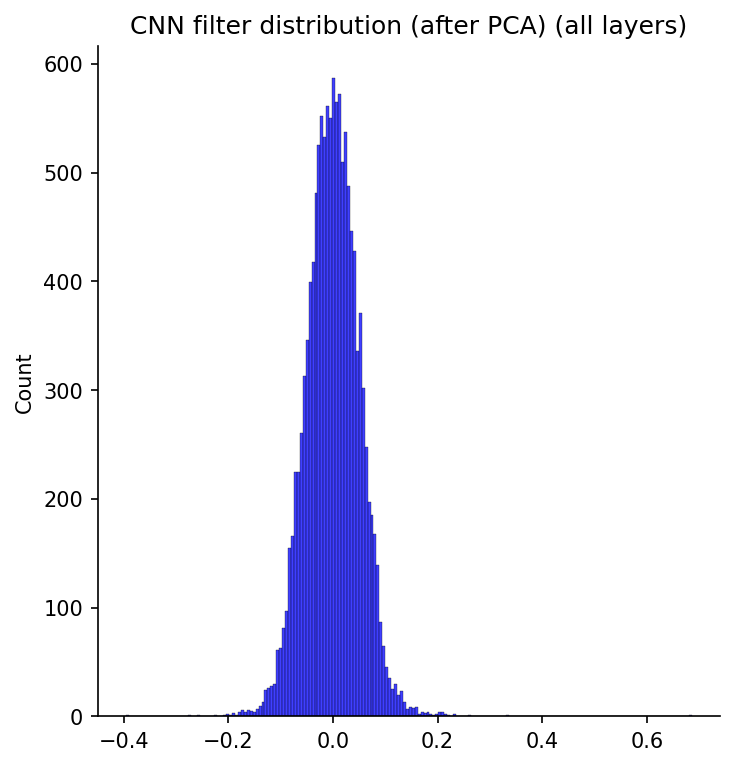

In [67]:
plot_conv_params_distrib(conv_params)

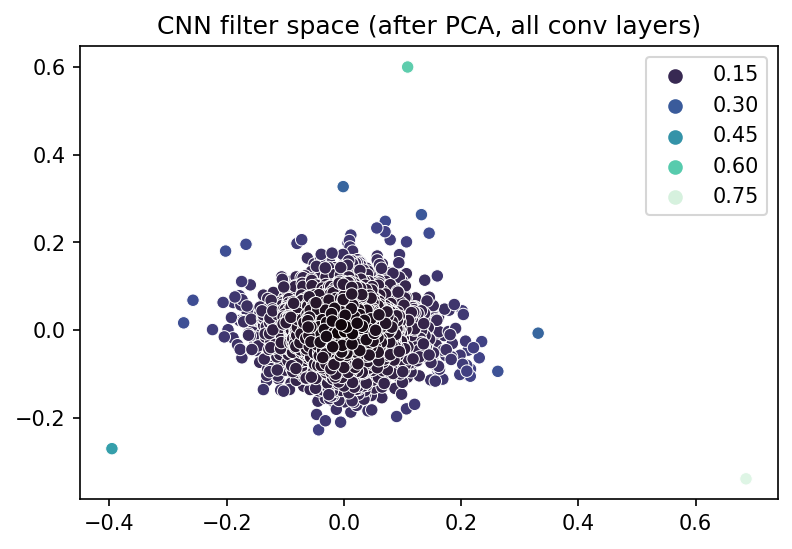

In [78]:
plot_conv_params_space(conv_params)